In [2]:
import json
import pandas as pd
import datetime as dt
import requests
import lxml.html
from lxml import html
from lxml.html.clean import Cleaner
import re
%matplotlib inline
from time import sleep
from random import randint
import csv
import matplotlib.pyplot as plt


In [119]:
# clean data
df = pd.read_csv('data/dc-property-sales-1.csv')
df = pd.concat([df, pd.read_csv('data/dc-property-sales-2.csv')])

df['sale_date'] = pd.to_datetime(df['sale_date'])
df['sale_price'] = df['sale_price'].str.replace('$','').str.replace(',','').replace('.00','0').astype(float)
df['square'] = df.square_suffix.str.extract('(\S*)\s', expand=False)
df['suffix'] = df.square_suffix.str.extract('(.{4})\s*$', expand=False)
df['address'] = df.address.str.lower()
df.fillna(value='', inplace=True)

residential = [1,2,3,11,12,13,15,16,17,19]
df['is_residential'] = False
df.loc[(df.use_code.isin(residential)), 'is_residential'] = True


In [54]:
df

,address,listing_url,neighborhood,owner,sale_date,sale_price,square_suffix,subneighborhood,use_code,square,suffix,is_residential
0,2600 pennsylvania av nw unit: 0201,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,HOLLIE S WONG UNIT 201,2015-04-20,660000.0,0004N 2001,,17,0004N,2001,True
1,2600 pennsylvania av nw unit: 0202,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,FABIOLA D J VALENCIA REVOCABLE TRUST OF 2004,2004-06-25,0.0,0004N 2002,,17,0004N,2002,True
2,2600 pennsylvania av nw unit: 0203,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,MARIA E ZAVALA APT 203,2001-08-07,525000.0,0004N 2003,,17,0004N,2003,True
3,2600 pennsylvania av nw unit: 0204,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,MARC PETERS APT 204,2001-10-12,550000.0,0004N 2004,,17,0004N,2004,True
4,2600 pennsylvania av nw unit: 0301,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,NEST USA INC UNIT 755,2007-08-23,825000.0,0004N 2005,,17,0004N,2005,True
5,2600 pennsylvania av nw unit: 0302,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,C BEYDA STE 555,2001-08-02,525000.0,0004N 2006,,17,0004N,2006,True
6,2600 pennsylvania av nw unit: 0303,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,THERESA A SNIDER,2005-05-17,850000.0,0004N 2007,,17,0004N,2007,True
7,2600 pennsylvania av nw unit: 0304,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,DANILO A MAIA,2013-02-01,805000.0,0004N 2008,,17,0004N,2008,True
8,2600 pennsylvania av nw unit: 0401,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,SUSAN CLAIRE GEORGE BRODARICK REVOCABLE TRUST,2006-01-27,850000.0,0004N 2009,,17,0004N,2009,True
9,2600 pennsylvania av nw unit: 0402,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,ANN SCHROEDER UNIT 402,2011-02-16,0.0,0004N 2010,,17,0004N,2010,True


In [29]:
# create list for geocode

# bulk geocoding
# https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form

chunk_size = 10000
number_of_files = len(df) // chunk_size + 1

df['zip'] = ''
df['city'] = 'Washington'
df['state'] = 'DC'


for i in range(number_of_files):
    
    df_addresses = df[['address','city','state','zip']][i*chunk_size:(i+1)*chunk_size]
    
    filename = 'data/address-export-for-bulk-latlong-' + str(i) + '.csv'
    
    df_addresses.to_csv(filename, header=False)

    



In [120]:
# get geocode and merge

df_zip = pd.DataFrame()

for i in range(14):
#     df_zip = pd.read_csv('data/GeocodeResults (0).csv', header=None, names=('address','match','match_type','address_geocode','latlong','unknown','lr'))

    filename = 'data/GeocodeResults (' + str(i) + ').csv'
    df_zip = pd.concat([df_zip, pd.read_csv(filename , header=None, names=('address','match','match_type','address_geocode','latlong','unknown','lr'))])

# df_zip = df_zip[df_zip.latlong.notnull()]
df_zip.address = df_zip.address.str.replace(', Washington, DC, ','')

df_zip['latitude'] = df_zip.latlong.str.split(',').str.get(1).astype(float)
df_zip['longitude'] = df_zip.latlong.str.split(',').str.get(0).astype(float)


df_zip.shape

(136045, 9)

In [121]:
# export

df = df.merge(df_zip[['address','address_geocode','latitude','longitude']], how='left', on='address')

print('with latlong: ',df[df.longitude.notnull()].shape)
df.to_csv('data/dc-housing-data-enriched.csv')

df

with latlong:  (176691, 15)


,address,listing_url,neighborhood,owner,sale_date,sale_price,square_suffix,subneighborhood,use_code,square,suffix,is_residential,address_geocode,latitude,longitude
0,2600 pennsylvania av nw unit: 0201,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,HOLLIE S WONG UNIT 201,2015-04-20,660000.0,0004N 2001,,17,0004N,2001,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
1,2600 pennsylvania av nw unit: 0202,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,FABIOLA D J VALENCIA REVOCABLE TRUST OF 2004,2004-06-25,0.0,0004N 2002,,17,0004N,2002,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
2,2600 pennsylvania av nw unit: 0203,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,MARIA E ZAVALA APT 203,2001-08-07,525000.0,0004N 2003,,17,0004N,2003,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
3,2600 pennsylvania av nw unit: 0204,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,MARC PETERS APT 204,2001-10-12,550000.0,0004N 2004,,17,0004N,2004,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
4,2600 pennsylvania av nw unit: 0301,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,NEST USA INC UNIT 755,2007-08-23,825000.0,0004N 2005,,17,0004N,2005,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
5,2600 pennsylvania av nw unit: 0302,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,C BEYDA STE 555,2001-08-02,525000.0,0004N 2006,,17,0004N,2006,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
6,2600 pennsylvania av nw unit: 0303,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,THERESA A SNIDER,2005-05-17,850000.0,0004N 2007,,17,0004N,2007,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
7,2600 pennsylvania av nw unit: 0304,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,DANILO A MAIA,2013-02-01,805000.0,0004N 2008,,17,0004N,2008,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
8,2600 pennsylvania av nw unit: 0401,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,SUSAN CLAIRE GEORGE BRODARICK REVOCABLE TRUST,2006-01-27,850000.0,0004N 2009,,17,0004N,2009,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850
9,2600 pennsylvania av nw unit: 0402,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,ANN SCHROEDER UNIT 402,2011-02-16,0.0,0004N 2010,,17,0004N,2010,True,"2600 PENNSYLVANIA AVE NW, WASHINGTON, DC, 20037",38.904160,-77.054850


In [122]:


df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 252083 entries, 0 to 252082
Data columns (total 15 columns):
address            252083 non-null object
listing_url        252083 non-null object
neighborhood       252083 non-null object
owner              252083 non-null object
sale_date          252083 non-null datetime64[ns]
sale_price         252083 non-null float64
square_suffix      252083 non-null object
subneighborhood    252083 non-null object
use_code           252083 non-null int64
square             252083 non-null object
suffix             252083 non-null object
is_residential     252083 non-null bool
address_geocode    176691 non-null object
latitude           176691 non-null float64
longitude          176691 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), object(9)
memory usage: 29.1+ MB


In [123]:
df.neighborhood.value_counts()

OLD CITY II                45979
FOREST HILLS               29869
CENTRAL                    20545
OLD CITY I                 16707
COLUMBIA HEIGHTS           13988
DEANWOOD                   12269
HILLCREST                   6324
BROOKLAND                   5860
PETWORTH                    5605
GEORGETOWN                  5388
CHEVY CHASE                 5091
WOODRIDGE                   4785
CONGRESS HEIGHTS            4573
BRIGHTWOOD                  4567
RANDLE HEIGHTS              4440
MOUNT PLEASANT              4284
R.L.A. SW                   3768
CAPITOL HILL                3563
FORT DUPONT PARK            3352
TRINIDAD                    3174
CLEVELAND PARK              3043
KALORAMA                    2956
GARFIELD                    2372
16TH ST. HEIGHTS            2337
ECKINGTON                   2236
ANACOSTIA                   2225
WESLEY HEIGHTS              2050
AMERICAN UNIV. PARK         2030
GLOVER PARK                 2027
MARSHALL HEIGHTS            1954
FOGGY BOTT

In [124]:
df.use_code.value_counts()

18     58261
11     31672
17     23415
16     20259
12     19499
93     14060
13     10003
94      9851
91      9376
217     8529
24      6436
192     6190
22      5011
191     3607
194     3420
23      3298
64      2857
193     1921
52      1726
21      1554
14      1322
49      1066
42       820
47       769
92       590
32       578
51       561
195      448
96       445
41       442
       ...  
365       21
86        19
69        19
88        16
66        16
31        16
34        14
165       13
82        12
27        11
196       10
85         9
87         9
37         8
73         7
36         7
35         6
265        6
95         6
53         5
465        4
71         4
117        4
43         4
126        2
76         1
33         1
189        1
116        1
127        1
Name: use_code, Length: 92, dtype: int64

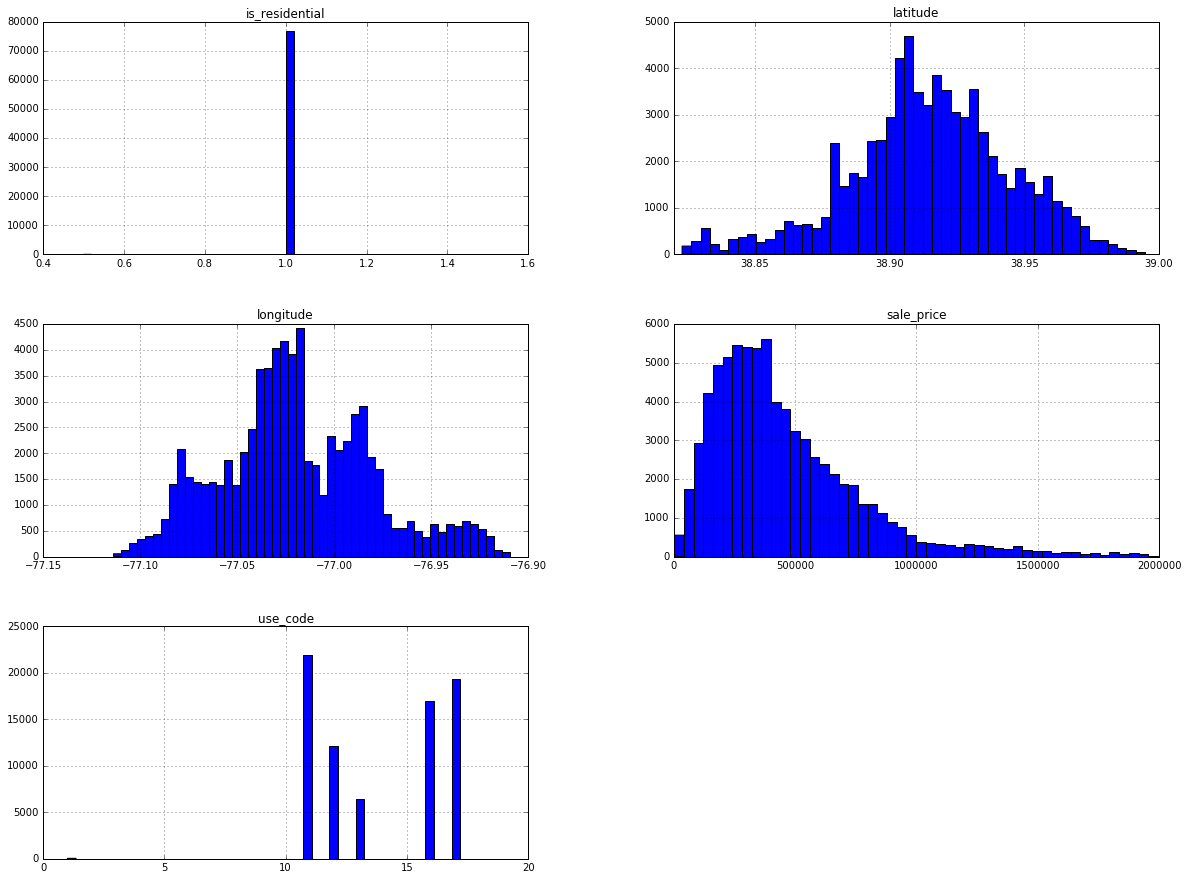

In [125]:
df = df[((df.is_residential) & (df.sale_price < 5000000) & (df.sale_price > 1000))]

df.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

In [75]:
df.describe()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 76821 entries, 0 to 252074
Data columns (total 15 columns):
address            76821 non-null object
listing_url        76821 non-null object
neighborhood       76821 non-null object
owner              76821 non-null object
sale_date          76821 non-null datetime64[ns]
sale_price         76821 non-null float64
square_suffix      76821 non-null object
subneighborhood    76821 non-null object
use_code           76821 non-null int64
square             76821 non-null object
suffix             76821 non-null object
is_residential     76821 non-null bool
address_geocode    73682 non-null object
latitude           73682 non-null float64
longitude          73682 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), object(9)
memory usage: 8.9+ MB


In [76]:
#df['sale_price'] = df['sale_price'].str.replace('$','').str.replace(',','').replace('.00','0').astype(float)
# df.sale_price.hist(bins=50)
# #df.use_code.unique()
#  #   5 12 21 32 34 38
# df.sale_price.max()
# missing 280 and 741
#df.sale_price.mean()
# residential = [1,2,3,11,12,13,15,16,17,19]

# #df.use_code.value_counts()
# df_res = df[(df.use_code.isin(residential))] #.shape
#df_res = df[((df.use_code.isin(residential)) & (df.sale_price > 0))] #.shape
# 100k rows
# df_res.groupby(['square', 'suffix'])['address'].first() #.max()
# # 77k with sale price

# #df_res.shape
# df_res.square_suffix.value_counts()

# #df['square'] = re.compile('(\d*)\s').df['square_suffix']
# # df[((df.owner.str.contains('DOLL')))]
# # df.suffix.unique()
# df.suffix.unique()
df[df.address.str.contains('kilbourne')]

,address,listing_url,neighborhood,owner,sale_date,sale_price,square_suffix,subneighborhood,use_code,square,suffix,is_residential,address_geocode,latitude,longitude
155407,1614 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,DAVID SITOMER,2010-12-22,218000.0,2596 0656,A,13,2596,0656,True,"1614 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.038300,38.930725
155743,1812 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,RUSSELL R CROSS,2004-12-08,675000.0,2599 0064,A,11,2599,0064,True,"1812 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.041690,38.930570
155744,1810 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,ERIK A HOFFLAND,2014-06-05,940000.0,2599 0065,A,11,2599,0065,True,"1810 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.041650,38.930570
155745,1808 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,CHRISTOPHER S FRANGIONE,2011-05-05,859000.0,2599 0066,A,11,2599,0066,True,"1808 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.041620,38.930570
155749,1822 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,KEVIN M STORM,2005-09-09,750000.0,2599 0072,A,11,2599,0072,True,"1822 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.041870,38.930570
155751,1814 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,JOHN C SILSBY,2003-08-01,530000.0,2599 0076,A,11,2599,0076,True,"1814 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.041725,38.930570
155752,1832 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,LEWIS YELIN,2004-07-23,646500.0,2599 0077,A,11,2599,0077,True,"1832 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.042046,38.930570
155754,1718 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,ALEXANDRA P BURNS,2008-09-05,840000.0,2600 0046,A,11,2600,0046,True,"1718 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.039430,38.930560
155756,1714 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,JOHN J CRONLEY,2003-12-10,600000.0,2600 0048,A,11,2600,0048,True,"1714 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.039345,38.930557
155758,1706 kilbourne pl nw,https://www.taxpayerservicecenter.com/RP_Detai...,MOUNT PLEASANT,TIMOTHY B LEE,2015-07-01,990000.0,2600 0084,A,11,2600,0084,True,"1706 KILBOURNE PL NW, WASHINGTON, DC, 20010",-77.039180,38.930557


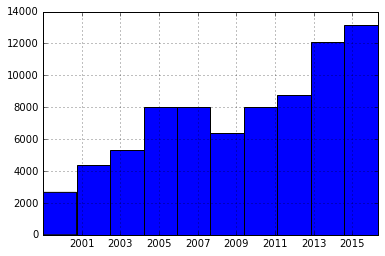

In [83]:
df.sale_date.hist()

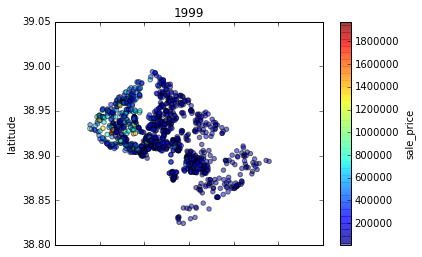

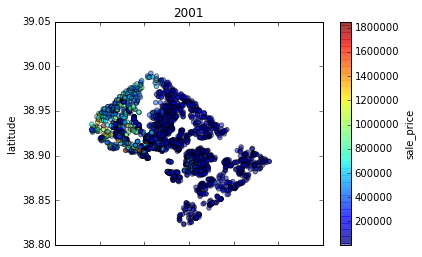

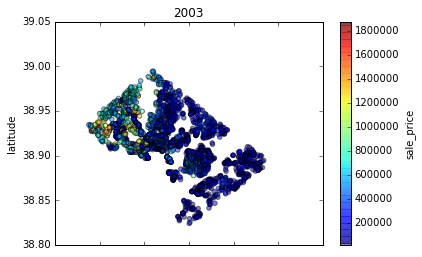

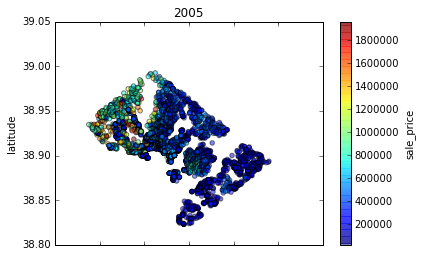

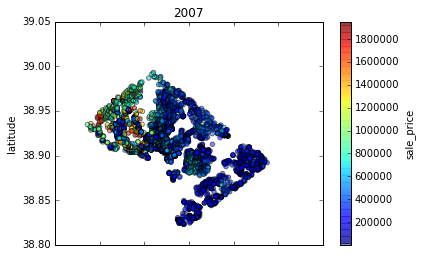

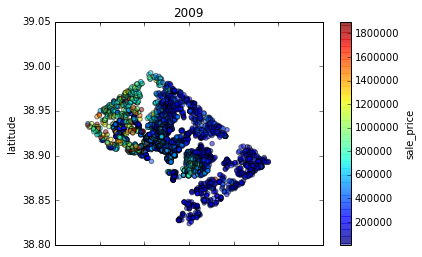

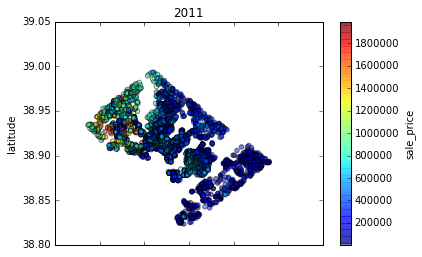

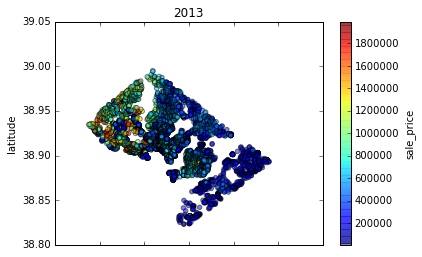

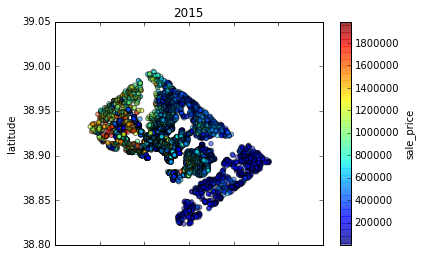

In [126]:
for year in range(df.sale_date.dt.year.min(),df.sale_date.dt.year.max() + 1, 2):
    
    df_plot = df[((df.sale_date.dt.year == year) & (df.is_residential == True))] #.sample(10)
    
#     print(df_plot)
    
    df_plot.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, title=year, c="sale_price", cmap=plt.get_cmap("jet"), colorbar=True)

In [128]:
df[df.is_residential == True].use_code.value_counts()

11    21903
17    19307
16    16947
12    12124
13     6463
1        52
15       20
19        5
Name: use_code, dtype: int64

In [97]:
df[((df.sale_price < 300000) & (df.sale_date.dt.year == 2015))]

,address,listing_url,neighborhood,owner,sale_date,sale_price,square_suffix,subneighborhood,use_code,square,suffix,is_residential,address_geocode,latitude,longitude
267,1001 26th st nw unit: 501,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,SARAH THOMAS,2015-10-06,270000.0,0015 2003,,17,0015,2003,True,"1001 26TH ST NW, WASHINGTON, DC, 20037",-77.054740,38.902668
336,1010 25th st nw unit: 102,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,ANNA R ARYANKALAYIL,2015-12-08,285000.0,0015 2094,,17,0015,2094,True,"1010 25TH ST NW, WASHINGTON, DC, 20037",-77.053314,38.902760
350,1010 25th st nw unit: 304,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,CLELIA BLANCA BERINDOAGUE TRUSTEE,2015-06-02,299000.0,0015 2111,,17,0015,2111,True,"1010 25TH ST NW, WASHINGTON, DC, 20037",-77.053314,38.902760
391,1010 25th st nw unit: 311,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,JORDAN MARGARET NORMA FISHER,2015-07-23,275000.0,0015 2163,,17,0015,2163,True,"1010 25TH ST NW, WASHINGTON, DC, 20037",-77.053314,38.902760
412,2515 k st nw unit: 602,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,ANTHONY BOCCHICCHIA,2015-03-24,230000.0,0015 2194,,17,0015,2194,True,"2515 K ST NW, WASHINGTON, DC, 20037",-77.053880,38.902500
425,2515 k st nw unit: 704,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,WILLIAM P QUINBY,2015-07-09,299000.0,0015 2209,,17,0015,2209,True,"2515 K ST NW, WASHINGTON, DC, 20037",-77.053880,38.902500
432,2515 k st nw unit: 206,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,NORMA E ORDONEZ,2015-03-30,215000.0,0015 2218,,17,0015,2218,True,"2515 K ST NW, WASHINGTON, DC, 20037",-77.053880,38.902500
447,2515 k st nw unit: 508,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,YANG GAO,2015-05-01,225000.0,0015 2235,,17,0015,2235,True,"2515 K ST NW, WASHINGTON, DC, 20037",-77.053880,38.902500
467,2515 k st nw unit: 711,https://www.taxpayerservicecenter.com/RP_Detai...,FOGGY BOTTOM,KIRA VUILLE-KOWING,2015-02-04,282500.0,0015 2258,,17,0015,2258,True,"2515 K ST NW, WASHINGTON, DC, 20037",-77.053880,38.902500
773,1275 25th st nw unit: 808,https://www.taxpayerservicecenter.com/RP_Detai...,CENTRAL,CARINE L ROSALIA,2015-05-07,291770.0,0024 5033,,17,0024,5033,True,"1275 25TH ST NW, WASHINGTON, DC, 20037",-77.053290,38.906578


In [ ]:
def property_analysis(group):

    # for each property
#     group['square'] = group.square
#     group['suffix'] = group.suffix
    group['sales'] = group.suffix.count()
    group['min_sale_price'] = group.sale_price.min()
    group['max_sale_price'] = group.sale_price.max()
    group['mean_sale_price'] = group.sale_price.mean()
    group['min_sale_date'] = group.sale_date.min()
    group['max_sale_date'] = group.sale_date.max()

    return group[0:1]

# cols = ['neighborhood', 'sales','min_sale_price','max_sale_price','min_sale_date','max_sale_date']

df_sales = df[df.sale_price > 0].sample(10000).groupby(['neighborhood']).apply(property_analysis) #[cols] 

# remove multilevel index
# df_sales.index = df_sales.index.droplevel(2)
# df_sales.index = df_sales.index.droplevel(1)
# df_sales.index.name = None
df_sales.sort_values('sales', ascending=False)



In [ ]:

df = df.copy()
df['year'], df['month'] = df['sale_date'].apply(lambda x: x.year), df['sale_date'].apply(lambda x: x.month)

df['sales_counts'] = df.groupby('neighborhood')['month'].transform('count')

df_year = df.groupby(['year','neighborhood']).mean().reset_index()

def analyze_price(group):
    
    first_year_with_price = group.year.min()
    starting_price = group[group.year == first_year_with_price].sale_price.min()
    
    group['relative_price'] = group.sale_price / starting_price
    
    return group

df_year = df_year.groupby('neighborhood').apply(analyze_price)

fig, ax = plt.subplots(figsize=(20,15))

for key, grp in df_year.groupby(['neighborhood']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='sale_price', label=key)

plt.legend(loc='best')
plt.show()



In [ ]:
fig, ax = plt.subplots(figsize=(20,15))

for key, grp in df_year[df_year.sales_counts > 2000].groupby(['neighborhood']):
    ax = grp.plot(ax=ax, kind='line', x='year', y='relative_price', label=key)

plt.legend(loc='best')
plt.show()

In [ ]:
df_year[df_year.sales_counts > 2000]

In [ ]:
df_year

In [ ]:
def year_analysis(group):

    # for each donor, get first and last donation
    group['donor_name'] = group.last_name
    group['year_donations'] = group.amount.sum()
    group['total_donations'] = df[df.donor_id == group.donor_id.tolist()[0]].amount.sum()
    group['year'] = group.name[0] 

    return group[0:1]

cols = ['donor_id','donor_name','year','year_donations', 'total_donations']

df_year = df.groupby((df['donation_date'].map(lambda x: x.year), df.donor_id)).apply(year_analysis)[cols] #.sort_values('amount', ascending=False).index.values[0:1].tolist()[0]

# remove multilevel index
df_year.index = df_year.index.droplevel(2)
df_year.index = df_year.index.droplevel(1)
df_year.index.name = None


In [ ]:
sales.sale_price.hist()